In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from bra_scraper import BRA


# Drabbas kommuner som tar emot många flyktingar av ökad brottslighet?

Så kallade invandringskritiker tycker om att påstå samband mellan flyktinginvandring och brottslighet. Framför allt då sexualbrottslighet.

Under 2015 och 2016 tog svenska kommuner emot rekordmånga flyktingar från framför allt Syrien och Afghanistan. Det här borde, om teorin om sambandet mellan invandring och brottslighet, synas i statistiken. Vi borde se en uppgång i sexual- och våldsbrott i de kommuner som tagit emot flest flyktingar, eller hur?

Men blev det så?

Brottsförebyggande rådet publicerade nyligen detaljerad statistik över antal anmälda brott i alla svenska kommuner. Nedan följer ett försök att besvara frågan med den här datan.


### Steg 1: Hämta data

Vi börjar med att hämta data från Brå i för ett antal olika brottstyper.

In [416]:
# Det här är de brott vi är intresserade av
crimes = [
    "Totalt antal brott",
    "Sexualbrott",
    u"Sexualbrott, Våldtäkt inkl. grov (ingår även i våldsbrott)",
    u"Sexualbrott, Våldtäkt inkl. grov (ingår även i våldsbrott), Mot samtliga personer, Utomhus",
    u"Våldsbrott",
    u"Våldsbrott, Misshandel inkl.grov",
    u"Stöld-, rån- och häleribrott", 
    u"Stöld-, rån- och häleribrott, Stöld och snatteri",
    u"Stöld-, rån- och häleribrott, Stöld och snatteri, I butik, varuhus, kommersiell utställningslokal",
    u"Skadegörelse (inkl. mordbrand)",
]

bra = BRA()

# Hämta data för riket och spara till fil
topic = bra.topic(u"Årsvis - Land och län 1975-2014, land och region 2015-")
topic.query(
    regions=["Hela landet"],
    crimes=crimes, 
    period_start="2000-01-01").to_csv("data/hela_landet.csv")


# Hämta data för kommuner och spara till fil
topic = bra.topic(u"Årsvis - Kommun och storstädernas stadsdelar 1996-")
topic.query(
    crimes=crimes, 
    period_start="2000-01-01").to_csv("data/kommuner.csv")

21 in surfer.py at 2017-03-17 14:47:19,096: Start new session
137 in topic.py at 2017-03-17 14:47:19,861: Making query of 1 regions, 10 crimes and 17 periods in Årsvis - Land och län 1975-2014, land och region 2015-.
140 in topic.py at 2017-03-17 14:47:19,862: Getting expected 170 datapoints
21 in surfer.py at 2017-03-17 14:47:19,863: Start new session
169 in topic.py at 2017-03-17 14:47:19,995: Parse result page 1 out of 1
185 in topic.py at 2017-03-17 14:47:21,909: Parsed 170 datapoints
9 in dataset.py at 2017-03-17 14:47:21,919: Writing to data/hela_landet.csv


Läs in fil för att harmonisera regionnamn från olika myndigeheter.

In [2]:
translate_df = pd.read_csv("../region_translations.csv", encoding="utf-8")
translate_df.head()

,region,kolada_id,migrationsverket_id,brå_id
0,Ale,Ale,ALE,Ale kommun
1,Alingsås,Alingsås,ALINGSÅS,Alingsås kommun
2,Alvesta,Alvesta,ALVESTA,Alvesta kommun
3,Aneby,Aneby,ANEBY,Aneby kommun
4,Arboga,Arboga,ARBOGA,Arboga kommun


Läs in befolkningsdata hämtad från Kolada.

In [4]:
population_df = pd.DataFrame().from_csv("data/kolada-befolkning.csv",encoding="utf-8").reset_index()

# Harmonisera region namnn
population_df = pd.merge(population_df, translate_df[["region","kolada_id"]], left_on="Region", right_on=u"kolada_id")\
    .rename(columns={ u"År": "year", u"Invånare": "population" })[["region", "year", "population" ]]\


population_df = population_df.set_index(["region","year"]).unstack()

# Lägg till Hela landet
country_pop = population_df.sum()
country_pop.name = "Hela landet"
population_df = population_df.append(country_pop)

# Räkna ut medelbefolkning senaste två åren
population_df["mean_pop"] = population_df.population[[2015, 2016]].mean(axis=1)
population_df.head()


population                                           mean_pop
year           2010   2011   2012   2013   2014   2015   2016         
region                                                                
Ale           27442  27577  27842  28074  28423  28862  29549  29205.5
Alingsås      37796  38053  38355  38619  39188  39602  40045  39823.5
Alvesta       18802  18917  19034  19280  19503  19581  19850  19715.5
Aneby          6393   6415   6407   6375   6426   6537   6603   6570.0
Arboga        13285  13302  13353  13493  13631  13858  13903  13880.5

Läs in data för antal mottagna asylsökande från Migrationsverket.

In [5]:
refugees_df = pd.DataFrame().from_csv("data/migrationsverket-mottagna-2015-2016.csv",encoding="utf-8").reset_index()

# Harmonisera regionnamnn
refugees_df = pd.merge(refugees_df, translate_df[["region","migrationsverket_id"]], left_on="Region", right_on=u"migrationsverket_id")\
    [["region", "2015", "2016"]].set_index("region")

refugees_df["refugees_count"] = refugees_df.sum(axis=1)

# Lägg till Hela landet
country_refugees = refugees_df.sum()
country_refugees.name = "Hela landet"
refugees_df = refugees_df.append(country_refugees)

# Hur många toppmottagande kommuner ska vi närstudera?
N_TOP_MUNIS = 20

refugees_df = refugees_df.join(population_df.mean_pop)[["refugees_count","mean_pop"]]
refugees_df["refugees_per_capita"] = refugees_df.refugees_count / refugees_df.mean_pop * 10000
refugees_df["refugees_rank"] = refugees_df.refugees_per_capita.rank(ascending=False)
is_top_recipient = refugees_df.refugees_rank <= N_TOP_MUNIS
refugees_df["top_refugee_muni"] = is_top_recipient
refugees_df.sort_values("refugees_per_capita", ascending=False).head(15).round()

# Lista på toppmottagare
TOP_REFUGEE_MUNIS = refugees_df[is_top_recipient].index.unique()

top_refugee_munis = refugees_df[is_top_recipient][["refugees_count","mean_pop"]].sum()
top_refugee_munis["refugees_per_capita"] = top_refugee_munis.refugees_count / top_refugee_munis.mean_pop * 10000
top_refugee_munis.name = "Toppmottagare"

refugees_df = refugees_df.append(top_refugee_munis)
refugees_df.sort_values("refugees_rank").head(10)

,refugees_count,mean_pop,refugees_per_capita,refugees_rank,top_refugee_muni
region,,,,,
Högsby,475.0,5968.5,795.844852,1.0,1.0
Hylte,678.0,10734.0,631.637786,2.0,1.0
Hultsfred,886.0,14263.0,621.187688,3.0,1.0
Lessebo,510.0,8638.0,590.414448,4.0,1.0
Ljusnarsberg,271.0,4967.0,545.600966,5.0,1.0
Avesta,1246.0,22971.0,542.423055,6.0,1.0
Östra Göinge,756.0,14254.0,530.377438,7.0,1.0
Mellerud,479.0,9246.0,518.061865,8.0,1.0
Hällefors,324.0,7085.0,457.304164,9.0,1.0


Slå ihop de tre dataseten (befolkning, flyktingmottagande och antal anmälda brott).

In [420]:
df_country = pd.DataFrame().from_csv(u"data/hela_landet.csv", encoding="utf-8")
df_municipality = pd.DataFrame().from_csv(u"data/kommuner.csv", encoding="utf-8")
# Remove old Heby
df_municipality= df_municipality[df_municipality.region_id!=8608]

df_long = pd.concat([df_municipality, df_country])


# Harmonisera regionnamnn
df_long = pd.merge(df_long, translate_df[["region",u"brå_id"]], left_on="region", right_on=u"brå_id")\
    .rename(columns={"region_y":"region"})

df_long.loc[:, "year"] = df_long.timepoint.str[:4]

df_long = df_long.set_index(["region","crime", "year"])[["value"]]

top_refugee_munis = df_long[df_long.index.get_level_values(level=0).isin(TOP_REFUGEE_MUNIS)].groupby(level=[1,2]).sum()
top_refugee_munis["region"] = "Toppmottagare"
top_refugee_munis = top_refugee_munis.reset_index().set_index(["region", "crime","year"])
df_long = pd.concat([df_long, top_refugee_munis])

YEARS = df_long.index.get_level_values(2).unique()
df = df_long.unstack()
df = pd.merge(df.value, refugees_df[["refugees_per_capita", "refugees_count","top_refugee_muni","mean_pop"]], left_index=True, right_index=True, how="left")


# Computed columns
df.loc[:, "latest"] = df["2016"]
df.loc[:, "avg"] = df[YEARS].mean(axis=1)

    # Standardavvikelse
df.loc[:, "stdev"] = df[YEARS].std(axis=1)
   
    # Hur långt från medel ligger senaste värdet medelvärdet innan 2016?
df.loc[:, "latest_vs_mean"] = df.latest / df.avg

df.loc[:, "latest_vs_2015"] = df.latest / df["2015"]


    # Hur många standardavvikelser ligger senaste värdet från medel?
df.loc[:, "latest_vs_mean_std"] = ( df.latest - df.avg ) / df.stdev


df.head()

2000  2001  2002  \
region crime                                                                  
Ale    Sexualbrott                                           10    14     8   
       Sexualbrott, Våldtäkt inkl. grov (ingår även i ...     3     2     1   
       Sexualbrott, Våldtäkt inkl. grov (ingår även i ...     0     0     0   
       Skadegörelse (inkl. mordbrand)                       219   191   209   
       Stöld-, rån- och häleribrott                        1551  1478  1504   

                                                           2003  2004  2005  \
region crime                                                                  
Ale    Sexualbrott                                           16    22    18   
       Sexualbrott, Våldtäkt inkl. grov (ingår även i ...     3     2     8   
       Sexualbrott, Våldtäkt inkl. grov (ingår även i ...     0     2     2   
       Skadegörelse (inkl. mordbrand)                       238   321   295   
       Stöld-, rån- och häleribrott                        1633  1762  1504   

                                                           2006  2007  2008  \
region crime                                                                  
Ale    Sexualbrott                                           22    17    12   
       Sexualbrott, Våldtäkt inkl. grov (ingår även i ...     8     4     6   
       Sexualbrott, Våldtäkt inkl. grov (ingår även i ...     1     0     2   
       Skadegörelse (inkl. mordbrand)                       227   334   550   
       Stöld-, rån- och häleribrott                        1107  1442  1467   

                                                           2009  \
region crime                                                      
Ale    Sexualbrott                                           20   
       Sexualbrott, Våldtäkt inkl. grov (ingår även i ...     9   
       Sexualbrott, Våldtäkt inkl. grov (ingår även i ...     5   
       Skadegörelse (inkl. mordbrand)                       541   
       Stöld-, rån- och häleribrott                        1321   

                                                                  ...          \
region crime                                                      ...           
Ale    Sexualbrott                                                ...           
       Sexualbrott, Våldtäkt inkl. grov (ingår även i ...         ...           
       Sexualbrott, Våldtäkt inkl. grov (ingår även i ...         ...           
       Skadegörelse (inkl. mordbrand)                             ...           
       Stöld-, rån- och häleribrott                               ...           

                                                           refugees_per_capita  \
region crime                                                                     
Ale    Sexualbrott                                                   64.371437   
       Sexualbrott, Våldtäkt inkl. grov (ingår även i ...            64.371437   
       Sexualbrott, Våldtäkt inkl. grov (ingår även i ...            64.371437   
       Skadegörelse (inkl. mordbrand)                                64.371437   
       Stöld-, rån- och häleribrott                                  64.371437   

                                                           refugees_count  \
region crime                                                                
Ale    Sexualbrott                                                  188.0   
       Sexualbrott, Våldtäkt inkl. grov (ingår även i ...           188.0   
       Sexualbrott, Våldtäkt inkl. grov (ingår även i ...           188.0   
       Skadegörelse (inkl. mordbrand)                               188.0   
       Stöld-, rån- och häleribrott                                 188.0   

                                                           top_refugee_muni  \
region crime                                                                  
Ale    Sexualbrott                                                      0.0   
       

### Steg 2: Analys

Vi börjar med att bara titta på hur antal brottsanmälningar utvecklats i hela landet under de senaste tio åren.  

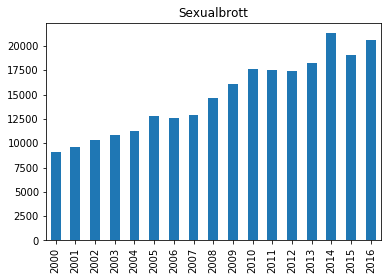

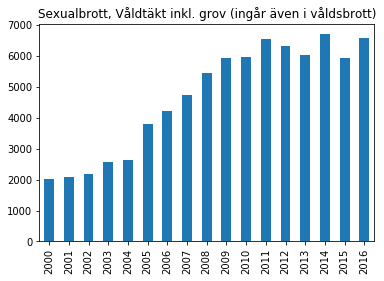

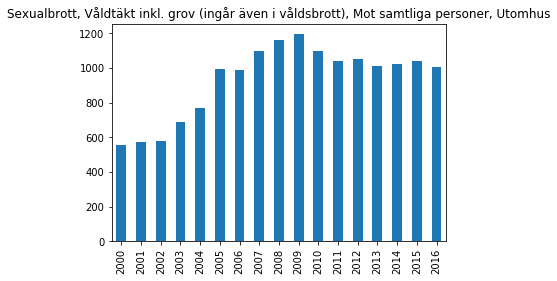

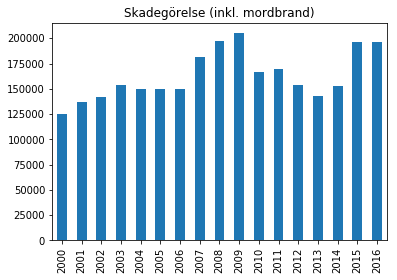

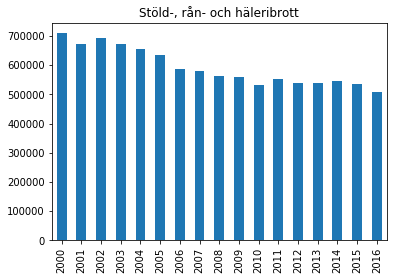

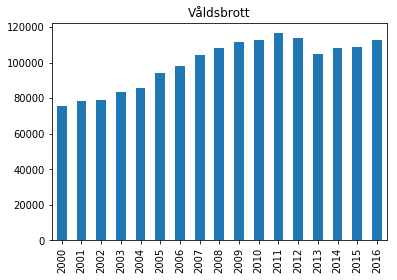

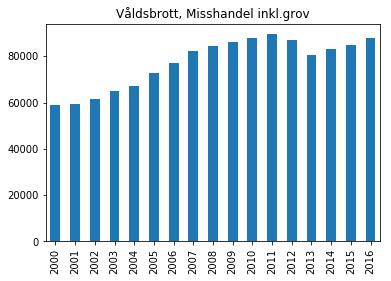

In [150]:
for crime, _df in df.groupby(level=1):
    _df.loc["Hela landet"][YEARS].T.plot.bar(title=crime, legend=False)


Sexualbrotten har tydligt gått upp, medan våldsbrotten ligger på en mer jämn nivå. Betyder det att invandringskritierna är nåt på spåren?

Låt oss titta närmare på de kommuner som tagit emot flest flyktingar i förhållande till sin folkmängd. Låg antalet anmälda brott 2016 över eller under medel?


In [7]:
print u"Toppmottagare: {}".format(", ".join(TOP_REFUGEE_MUNIS))

Toppmottagare: Avesta, Bengtsfors, Filipstad, Flen, Hultsfred, Hylte, Hällefors, Högsby, Lessebo, Ljusnarsberg, Markaryd, Mellerud, Ockelbo, Oxelösund, Ronneby, Sorsele, Storfors, Uppvidinge, Åmål, Östra Göinge


In [427]:
COLS = ["latest_vs_mean"]
table = pd.concat([df.loc["Toppmottagare"][COLS], df.loc["Hela landet"][COLS]], axis=1).round(2)
table.columns = ["Toppmottagare", "Hela landet"]
table

,Toppmottagare,Hela landet
crime,,
Sexualbrott,1.41,1.39
"Sexualbrott, Våldtäkt inkl. grov (ingår även i våldsbrott)",1.41,1.40
"Sexualbrott, Våldtäkt inkl. grov (ingår även i våldsbrott), Mot samtliga personer, Utomhus",0.99,1.07
Skadegörelse (inkl. mordbrand),0.90,1.20
"Stöld-, rån- och häleribrott",0.75,0.86
"Stöld-, rån- och häleribrott, Stöld och snatteri",0.78,0.90
"Stöld-, rån- och häleribrott, Stöld och snatteri, I butik, varuhus, kommersiell utställningslokal",0.78,0.85
Totalt antal brott,0.99,1.12
Våldsbrott,1.33,1.13


Slutsats: Nej, det finns ingen betydande skillnad i antal anmälda brott mellan toppmottagare och riket.

Nedan jämför vi toppmottagarna och riket år för år.

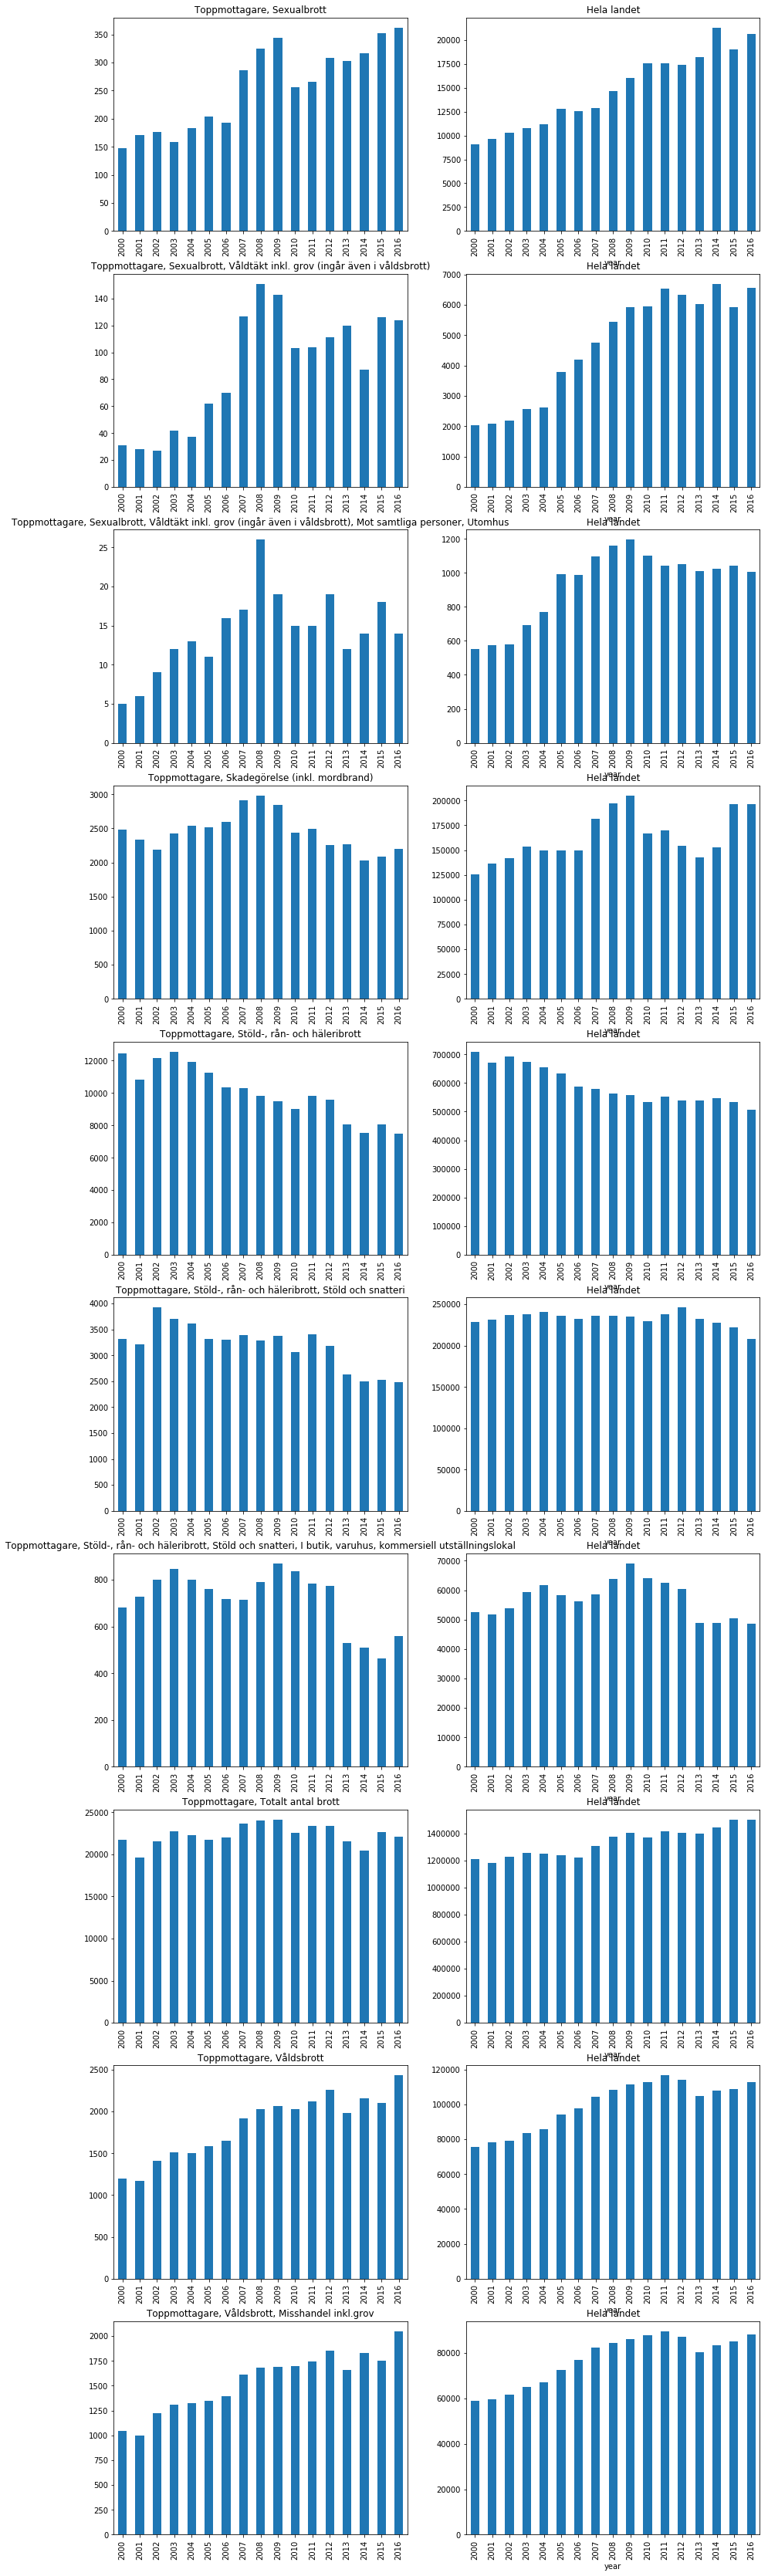

In [424]:
fig, axs = plt.subplots(nrows=len(crimes), ncols=2)

i = 0
for crime, _df in df.loc["Toppmottagare"].groupby(level=0):
    _df[YEARS].T.plot.bar(title=u"Toppmottagare, {}".format(crime), legend=False, ax = axs[i][0]).set_ylim(0)
    df.loc[("Hela landet", crime)][YEARS].T.plot.bar(title=u"Hela landet", legend=False, ax = axs[i][1]).set_ylim(0)
    i += 1

fig.set_size_inches(15, 6 * len(crimes))
plt.show()   

Låt oss även se om det finns nåt samband i form av korrelation. Vi jämför **antalet brott 2016 som avvikelse från medel** (mätt i standardavvikelser) mot **antal flyktingar per 10 000 invånare**. 

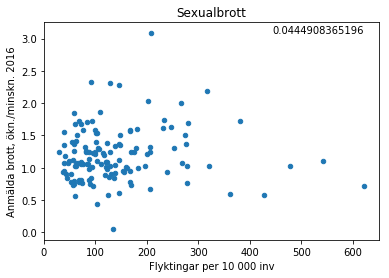

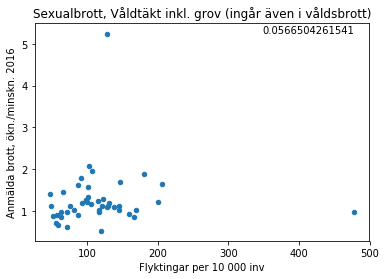

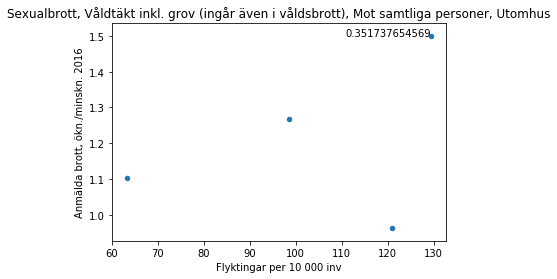

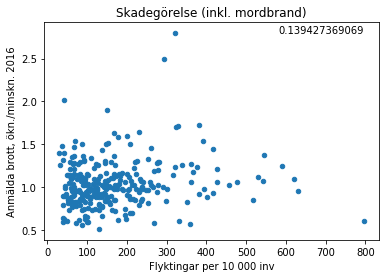

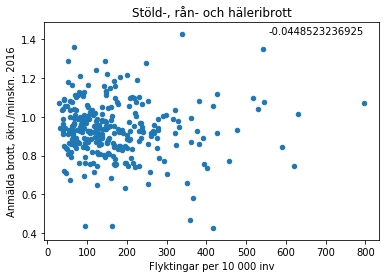

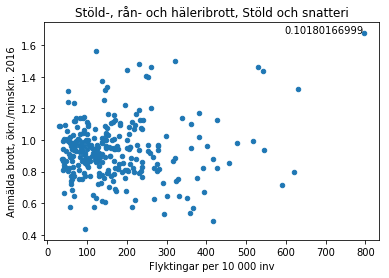

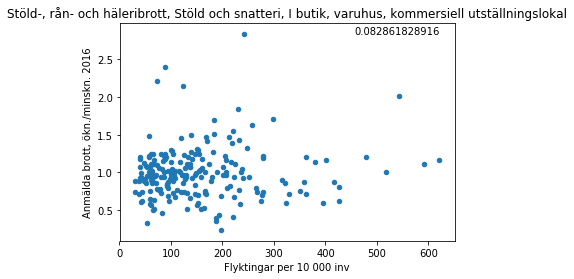

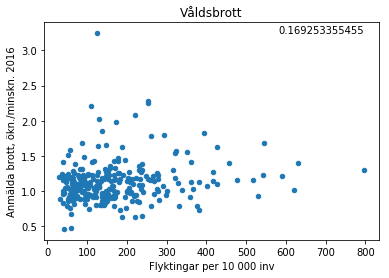

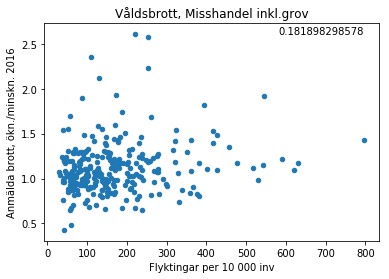

In [409]:
def plot_relation(crime, _df):
    measure = "latest_vs_mean_std" # latest_vs_mean | latest_vs_mean_std
    ax = _df.plot.scatter("refugees_per_capita", measure, title=crime)
    ax.set_xlabel(u"Flyktingar per 10 000 inv")
    ax.set_ylabel(u"Anmälda brott, ökn./minskn. 2016")
    corr = _df[["refugees_per_capita", measure]].corr().iloc[0,1]
    ax.text(_df.refugees_per_capita.max(),_df[measure].max(),corr, ha="right")
    
for crime, _df in df.groupby(level=1):
    # Plotta 
    plot_relation(crime, _df[_df.avg > 20])
    

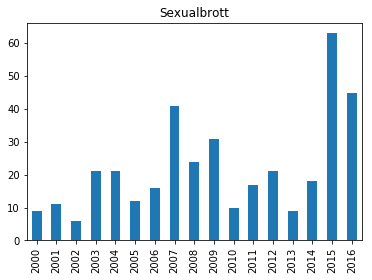

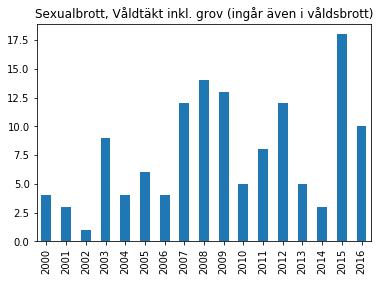

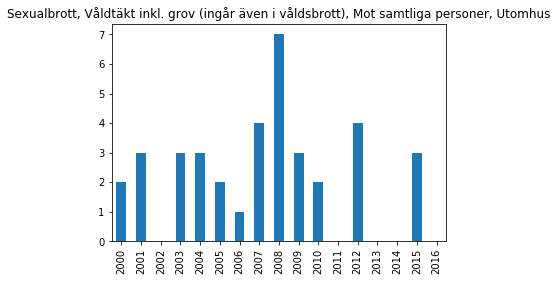

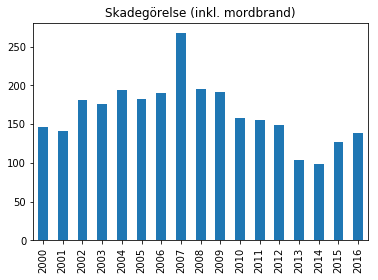

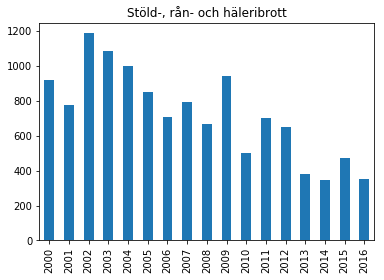

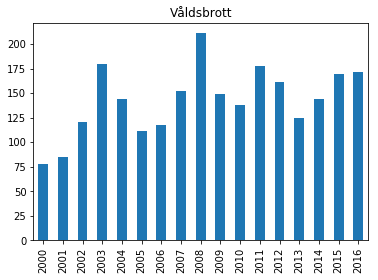

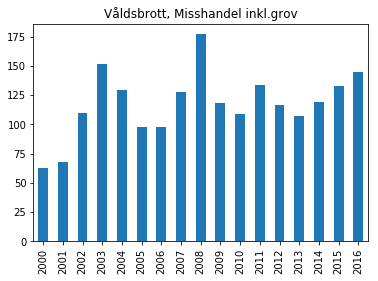

In [394]:
REGION = u"Toppmottagare"
for crime, _df in df.groupby(level=1):
    _df.loc[REGION][YEARS].T.plot.bar(title=crime, legend=False)
